In [1]:
%cd ../..

c:\Users\tacke\OneDrive\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python-2E-1


### Installing NeuralForecast (If Required)

In [2]:
# %%capture
# !pip install neuralforecast

### Common Imports

In [3]:
import numpy as np
import pandas as pd

### Common Functions and metrics

- The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.Importing it from `src/utils/plotting_utils.
- `average_length` isn't implemented in `utilsforecast`, and therefore we have implemented it the same way as the rest of the metrics. Importing it from `src/utils/ts_utils.py`.
- `level_to_quantiles` is a function that converts a level to a quantile. Importing it from `src/utils/ts_utils.py`.

In [4]:
from src.utils.ts_utils import average_length, level_to_quantiles
from src.utils.plotting_utils import plot_grid

### Loading M4 Data

Let's load the data and pick 8 time series to work with.

In [5]:
from src.utils.general import download_m4_data
import os
if not os.path.exists('data/m4/M4-Hourly.csv'):
    download_m4_data()
Y_train_df = pd.read_csv('data/m4/M4-Hourly.csv')
Y_test_df = pd.read_csv('data/m4/M4-Hourly-test.csv')#.rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long.

In [6]:
# Taking first n_series time series from the dataset
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

### Plotting Sampled TS

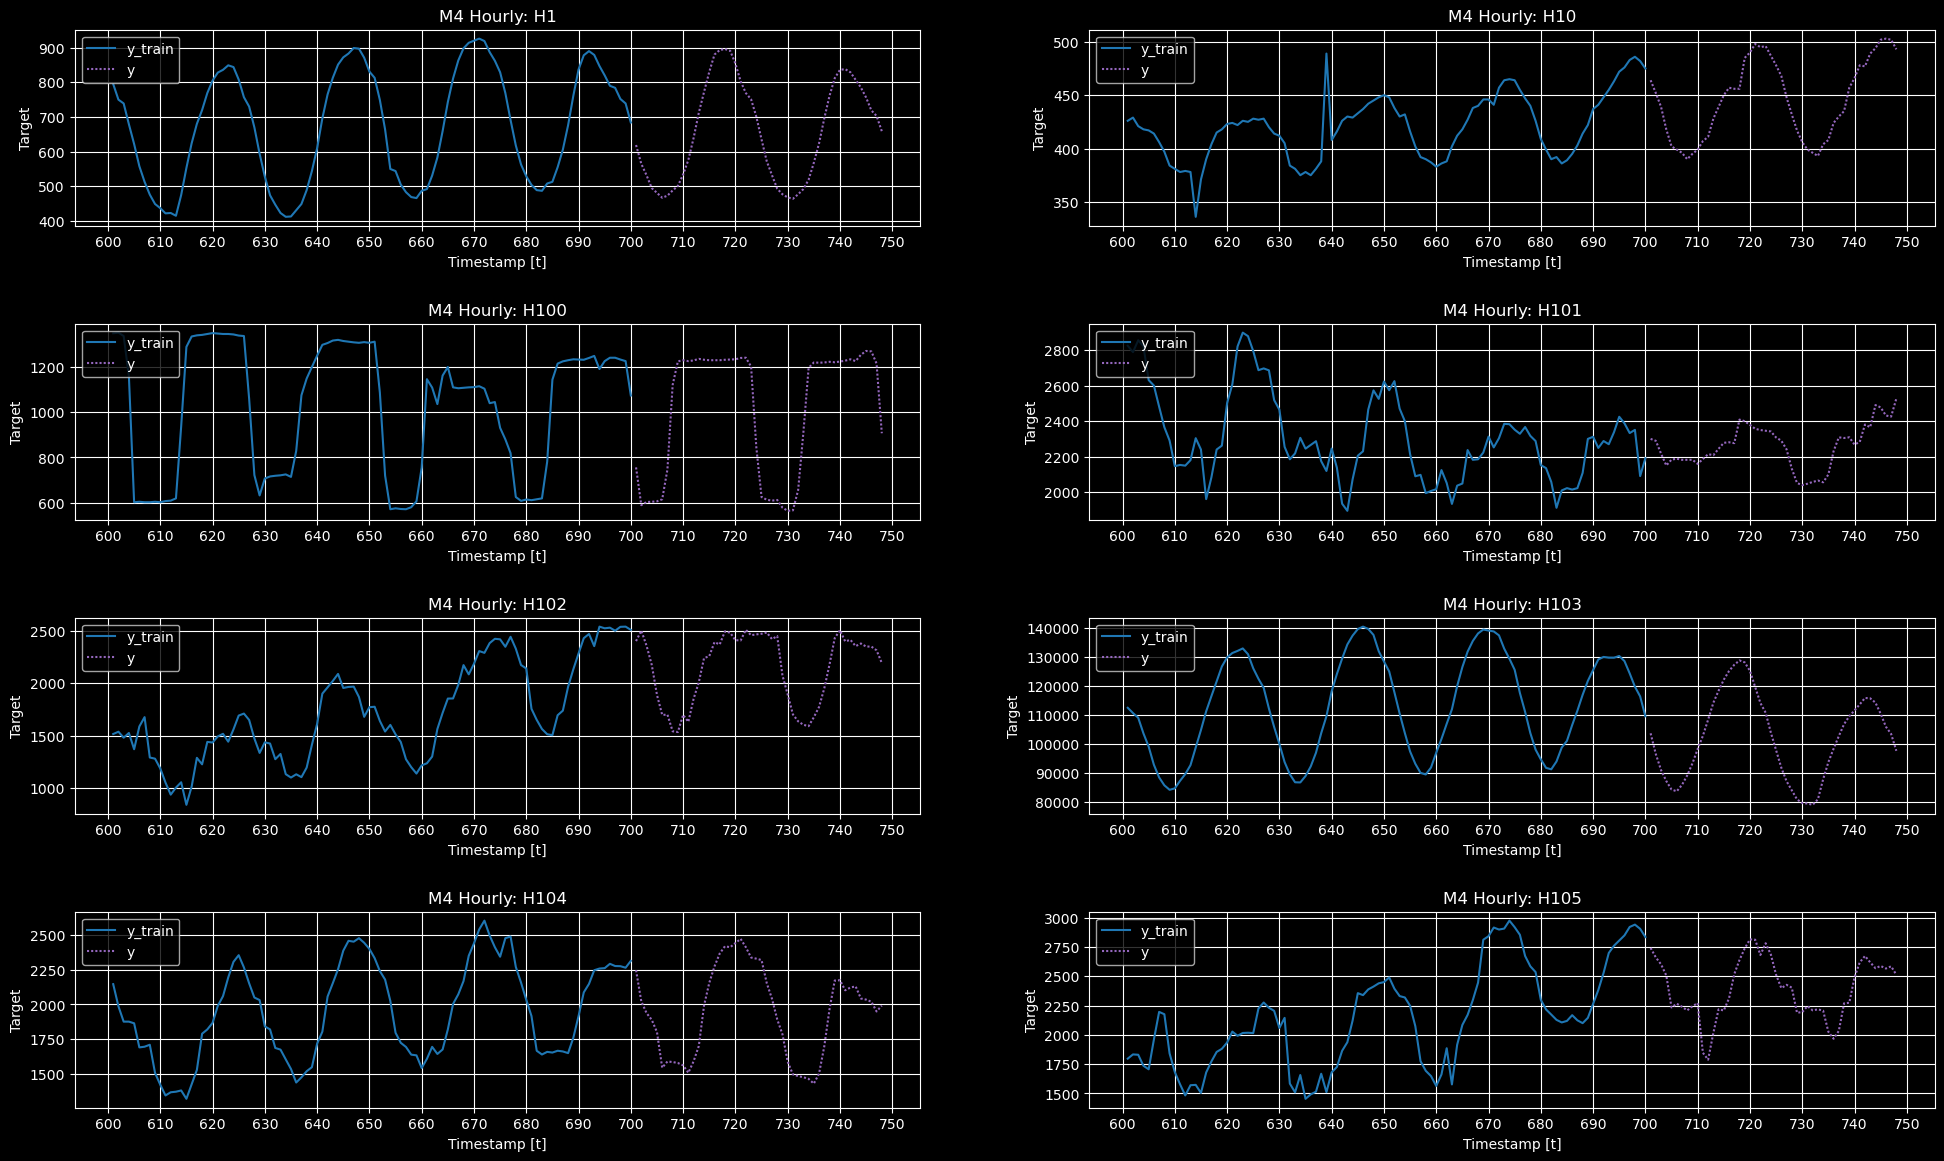

In [7]:
# Plotting the selected time series
plot_grid(Y_train_df, Y_test_df)

### Model Definition

In [8]:
from neuralforecast.losses.pytorch import MAE
import torch
import torch.nn as nn

from src.dl.nf_models import DNonLinear

#### Custom NeuralForecast Model

Let's import the custom model with below architecture (with dropouts before every weight)
```
     Input----------------------
      |                         |
Series Decomposition            |
      /\                        |
     /  \                       |
Trend   Seasonality             |
  |            |                |
Trend      Seasonality    Non-Linear Trend
Predictor   Predictor       Predictor
      |         |           |
      ----------------------
              (Add)
                |
              Output  
  
```

And we will be overriding the `predict_step` method to include MC Dropout inference.

In [9]:
def enable_dropout(model):
    """Function to enable the dropout layers during test-time"""
    for m in model.modules():
        if m.__class__.__name__.startswith("Dropout"):
            m.train()


class MCDropoutDNonLinear(DNonLinear):
    def predict_step(self, batch, batch_idx):
        enable_dropout(self)
        pred_samples = []
        # num_samples and levels will be saved to the model in MCNeuralForecast predict method
        for i in range(self.num_samples):
            y_hat = super().predict_step(batch, batch_idx)
            pred_samples.append(y_hat)
        # Stack the samples
        pred_samples = torch.stack(pred_samples, dim=0)
        # Calculate the median and the quantiles
        y_hat = [pred_samples.quantile(0.5, dim=0)]
        if self.levels is not None:
            for l in self.levels:
                lo, hi = level_to_quantiles(l)
                y_hat_lo = pred_samples.quantile(lo, dim=0)
                y_hat_hi = pred_samples.quantile(hi, dim=0)
                y_hat.extend([y_hat_lo, y_hat_hi])
        # Stack the results
        y_hat = torch.stack(y_hat, dim=-1)
        return y_hat

#### Custom Redefinition of the Neuralforecast class

In [10]:
from neuralforecast import NeuralForecast

In [11]:
class MCNeuralForecast(NeuralForecast):
    def __init__(self, num_samples, levels=None, **kwargs):
        super().__init__(**kwargs)
        self.num_samples = num_samples
        self.levels = levels

    def predict(
        self,
        df=None,
        static_df=None,
        futr_df=None,
        sort_df=True,
        verbose=False,
        engine=None,
        **data_kwargs,
    ):
        # Adding model columns to loss output names
        # Necessary hack to get the quantiles and format it correctly
        for model in self.models:
            model.loss.output_names = ["-median"]
            for l in list(self.levels):
                model.loss.output_names.append(f"-lo-{l}")
                model.loss.output_names.append(f"-hi-{l}")
            # Setting the number of samples and levels in the model
            model.num_samples = self.num_samples
            model.levels = self.levels
        return super().predict(
            df, static_df, futr_df, sort_df, verbose, engine, **data_kwargs
        )

### Model Training

In [12]:
horizon = len(Y_test_df.ds.unique()) # 48
levels = [80, 90]
model = MCDropoutDNonLinear(
    h=horizon,
    input_size=horizon*3,
    moving_avg_window=13,
    dropout=0.1,
    max_steps=500,
    early_stop_patience_steps=5,
)

mcnf = MCNeuralForecast(models=[model], freq=1, num_samples=100, levels=levels)
mcnf.fit(Y_train_df, val_size=horizon, verbose=True)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type          | Params
---------------------------------------------------
0 | loss             | MAE           | 0     
1 | padder_train     | ConstantPad1d | 0     
2 | scaler           | TemporalNorm  | 0     
3 | decomp           | SeriesDecomp  | 0     
4 | non_linear_block | Sequential    | 29.4 K
5 | linear_trend     | Sequential    | 7.0 K 
6 | seasonality      | Sequential    | 7.0 K 
---------------------------------------------------
43.4 K    Trainable params
0         Non-trainable params
43.4 K    Total params
0.173     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.


In [13]:
# Predicting for the next horizon (since we arent using any external regressors, we can just call predict)
# The output should have the point rediction (median) as well as the two prediction intervals according to the levels we have defined
Y_hat_df = mcnf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,MCDropoutDNonLinear-median,MCDropoutDNonLinear-lo-80,MCDropoutDNonLinear-hi-80,MCDropoutDNonLinear-lo-90,MCDropoutDNonLinear-hi-90
0,H1,701,625.148315,568.433960,687.198242,559.873535,694.731384
1,H1,702,573.860718,522.821594,629.152283,518.653015,635.825317
2,H1,703,528.621765,483.549469,589.128784,464.068176,596.609253
3,H1,704,472.391357,400.082092,528.695923,382.924591,552.844727
4,H1,705,449.857147,384.403168,505.325500,356.119995,519.743286


In [14]:
# Merging the predictions back to the test_df
Y_test_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

### Plotting Predictions

Let's plot the forecast and see how we did.

The output that represents the 90% prediction interval of the network; its lower limit gives the 5th percentile (or 0.05 quantile) while its upper limit gives the 95th percentile (or 0.95 quantile). For well-trained models we expect that the target values lie within the interval 90% of the time.

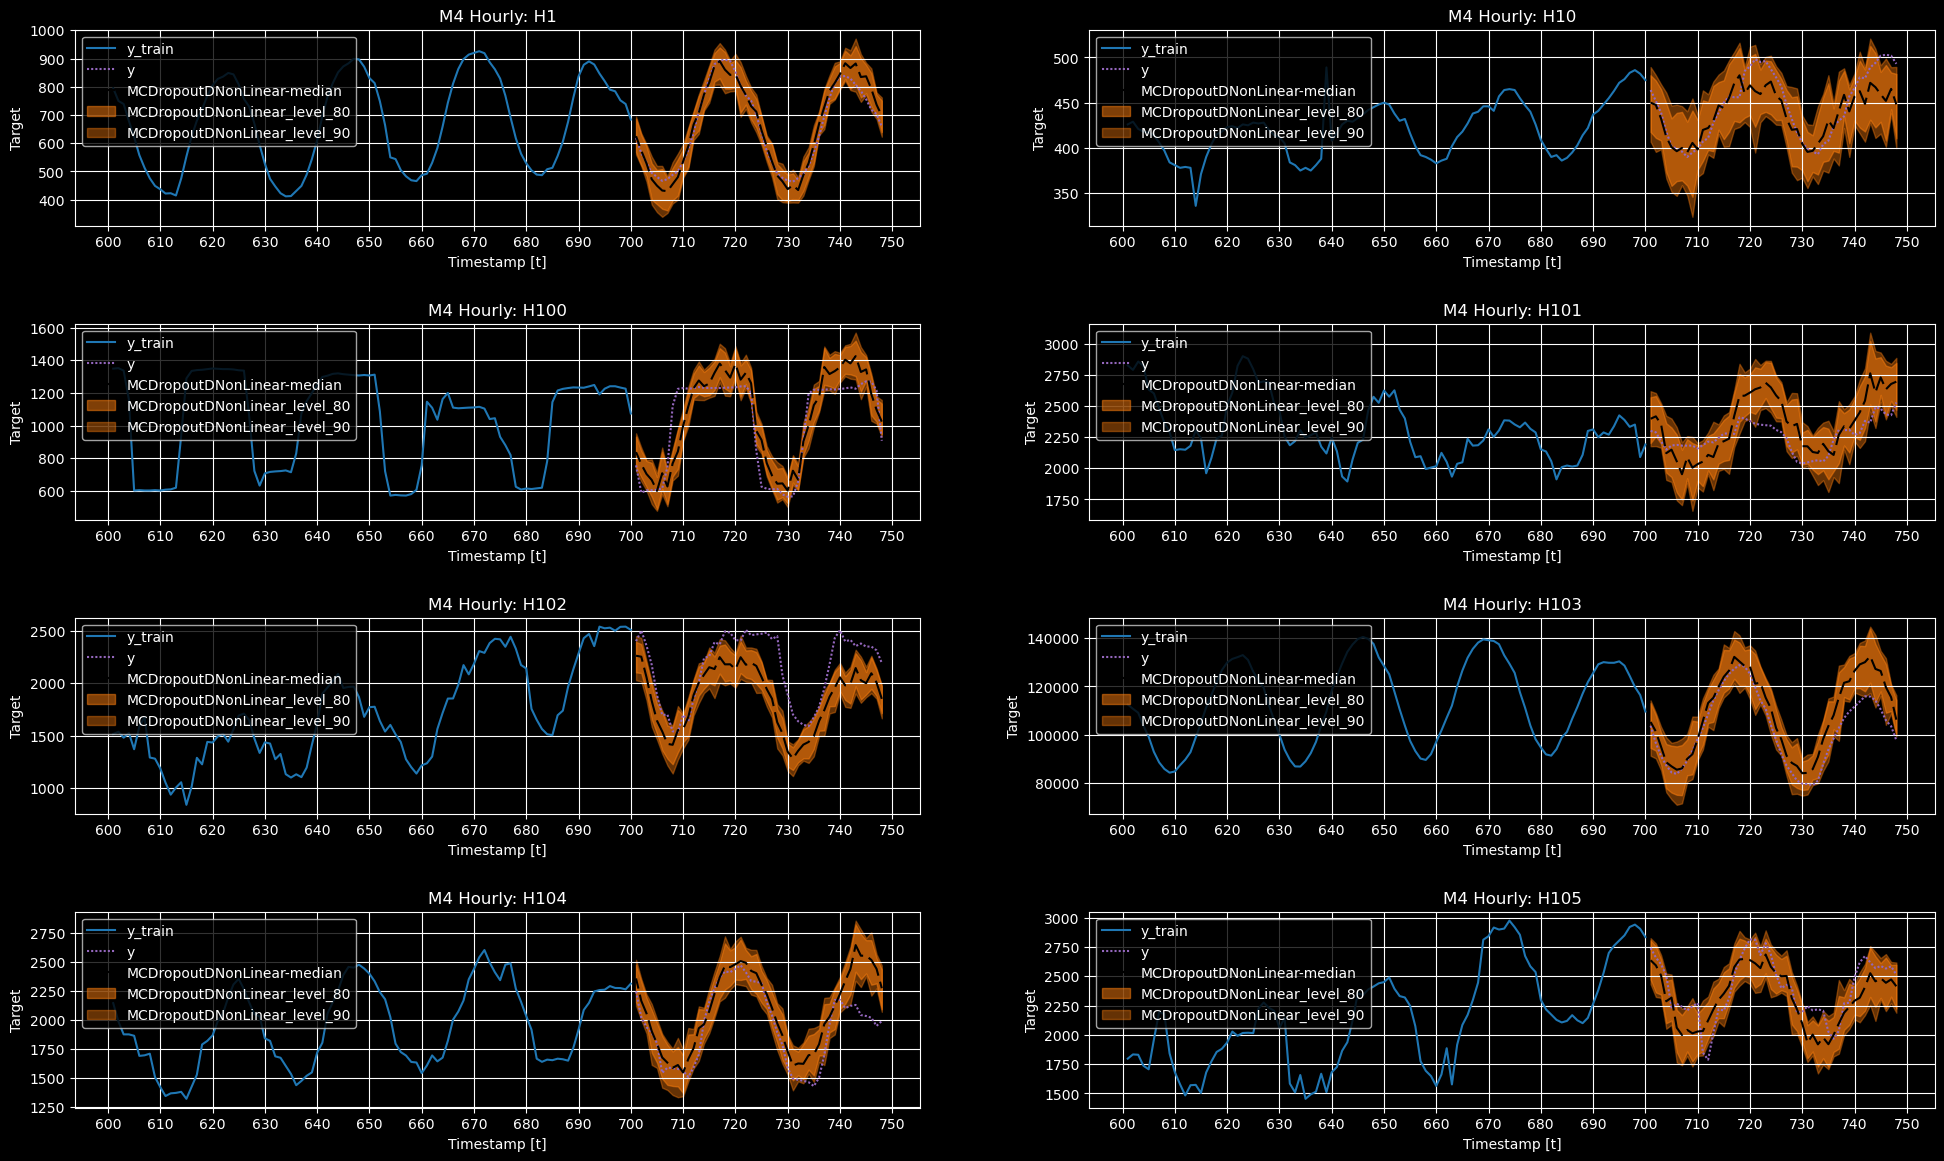

In [15]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='MCDropoutDNonLinear')

#### Metrics

In [16]:
from utilsforecast.losses import mae, coverage

In [17]:
res_df = mae(Y_test_df, models=['MCDropoutDNonLinear-median']).rename(columns={'MCDropoutDNonLinear-median': 'MCDropoutDNonLinear-mae'})
for l in levels:
    res_df = res_df.merge(coverage(Y_test_df, models=['MCDropoutDNonLinear'], level=l).rename(columns={'MCDropoutDNonLinear': f'MCDropoutDNonLinear-coverage-{l}'}), on='unique_id')
    res_df = res_df.merge(average_length(Y_test_df, models=['MCDropoutDNonLinear'], level=l).rename(columns={'MCDropoutDNonLinear': f'MCDropoutDNonLinear-average_length-{l}'}), on='unique_id')
res_df

,unique_id,MCDropoutDNonLinear-mae,MCDropoutDNonLinear-coverage-80,MCDropoutDNonLinear-average_length-80,MCDropoutDNonLinear-coverage-90,MCDropoutDNonLinear-average_length-90
0,H1,23.375669,0.875000,106.123720,0.958333,131.142998
1,H10,15.299514,0.875000,65.174679,0.895833,82.312977
2,H100,110.135901,0.458333,177.890294,0.625000,222.856785
3,H101,154.639969,0.708333,350.808057,0.791667,450.697980
4,H102,282.682167,0.145833,283.612460,0.291667,367.653992
5,H103,6364.926107,0.687500,16377.053711,0.812500,20489.444824
6,H104,149.012169,0.625000,313.994502,0.770833,402.729057
7,H105,140.380834,0.687500,343.677956,0.770833,428.900332
